## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt

In [31]:
file_name="/Users/andre/Downloads/data_000637.txt"
data=pd.read_csv(file_name)
nrw=len(data)-1
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


 2\. Find out the number of BX in a ORBIT (the value 'x').

In [32]:
x=data['BX_COUNTER'].max()+1
print('x: ',x)
y=data['TDC_MEAS'].max()+1
print('y: ',y)

x:  3564
y:  30


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [ ]:
#it's done in the next row of code

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).


In [33]:
bit=30 #unit time passed adding 1 to BX_COUNTER (it's 25, but if we use it there is a problem of carry using TDC_MEAS=30)
data.sort_values(by=['ORBIT_CNT','BX_COUNTER','TDC_MEAS'], inplace = True,ignore_index=True)
inc=np.zeros((len(data)))

mask=np.zeros((len(data)))
df=data.diff(periods=1, axis=0)

mask[df['ORBIT_CNT']==0]=1
mask[(df['BX_COUNTER']==0)&(df['ORBIT_CNT']==0)]=2
mask[df['ORBIT_CNT']!=0]=3

inc[mask==2]=df['TDC_MEAS'][mask==2]
inc[mask==1]=(df['BX_COUNTER'][mask==1]-1)*bit +df['TDC_MEAS'][mask==1] +y
inc[mask==3]=(df['BX_COUNTER'][mask==3]+x)*bit +data['TDC_MEAS'][mask==3]
inc[0]=0

data['ABS_TIME']=np.cumsum(inc)
print('Acquisition Time: ',data['ABS_TIME'][nrw]/(1000*1000),'ms')
data['ABS_TIME']=data['ABS_TIME'].astype(int)
tstamp = pd.Timestamp(datetime.now())
data['ABS_TIME']=pd.to_datetime(data['ABS_TIME']+tstamp.value, unit='ns')
data

Acquisition Time:  1176.201383 ms


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,2020-11-25 14:12:19.599718000
1,1,0,124,3869200167,2374,27,2020-11-25 14:12:19.599718001
2,1,0,63,3869200167,2553,28,2020-11-25 14:12:19.599723372
3,1,0,64,3869200167,2558,19,2020-11-25 14:12:19.599723513
4,1,0,64,3869200167,2760,25,2020-11-25 14:12:19.599729579
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,2020-11-25 14:12:20.775919187
1310716,1,0,61,3869211171,762,18,2020-11-25 14:12:20.775919191
1310717,1,1,4,3869211171,763,11,2020-11-25 14:12:20.775919214
1310718,1,0,64,3869211171,764,0,2020-11-25 14:12:20.775919233


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel



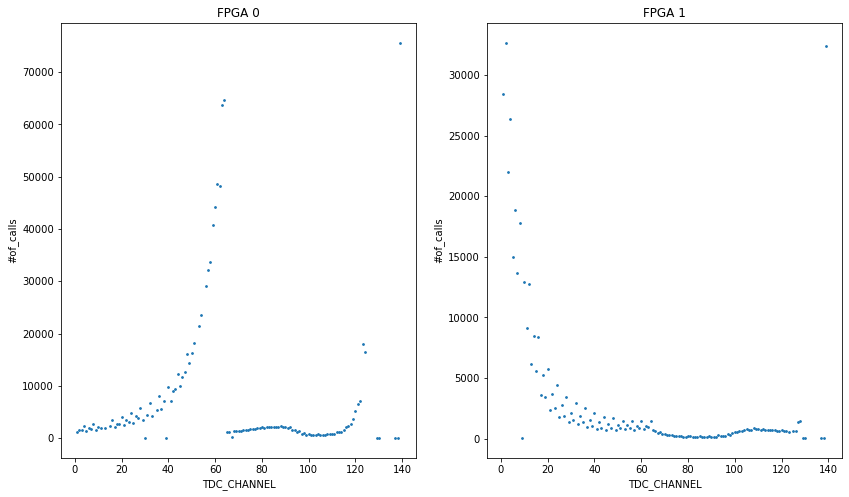

In [34]:
ind0=data[data['FPGA']==0].groupby(['TDC_CHANNEL']).count()['HEAD']
fig=plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.scatter(ind0.index,ind0,s=3)
plt.xlabel('TDC_CHANNEL');
plt.ylabel('#of_calls');
plt.title('FPGA 0');

ind1=data[data['FPGA']==1].groupby(['TDC_CHANNEL']).count()['HEAD']
plt.subplot(1,2,2)
plt.scatter(ind1.index,ind1,s=3)
plt.xlabel('TDC_CHANNEL');
plt.ylabel('#of_calls');
plt.title('FPGA 1');

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)



In [35]:
ind=data.groupby(['TDC_CHANNEL']).count()['HEAD']
indx=ind.index
dtC=np.zeros(len(indx))
for i in range(len(indx)):
    dtC[i]=data[data['TDC_CHANNEL']==indx[i]]['BX_COUNTER'].cumsum().max()
dt=pd.DataFrame({'TDC_CHANNEL_INDX': indx,'#_CALL': dtC})
dt.sort_values(by='#_CALL',ascending=False)

,TDC_CHANNEL_INDX,#_CALL
132,139,192477704.0
63,64,117767051.0
62,63,115482430.0
60,61,88234674.0
61,62,87956183.0
...,...,...
125,126,1062095.0
131,138,128317.0
129,130,124418.0
130,137,123920.0


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [40]:
ind=data[data['TDC_CHANNEL']==139].groupby(['ORBIT_CNT']).count()['HEAD']
ind=ind[ind>0]
print('# of unique orbits: ',len(ind))

# of unique orbits:  10976


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.


In [37]:
data['HEAD']=np.random.rand(len(data))
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,0.782754,0,123,3869200167,2374,26,2020-11-25 14:12:19.599718000
1,0.798936,0,124,3869200167,2374,27,2020-11-25 14:12:19.599718001
2,0.167785,0,63,3869200167,2553,28,2020-11-25 14:12:19.599723372
3,0.889316,0,64,3869200167,2558,19,2020-11-25 14:12:19.599723513
4,0.037993,0,64,3869200167,2760,25,2020-11-25 14:12:19.599729579
...,...,...,...,...,...,...,...
1310715,0.865828,0,62,3869211171,762,14,2020-11-25 14:12:20.775919187
1310716,0.856878,0,61,3869211171,762,18,2020-11-25 14:12:20.775919191
1310717,0.968825,1,4,3869211171,763,11,2020-11-25 14:12:20.775919214
1310718,0.283946,0,64,3869211171,764,0,2020-11-25 14:12:20.775919233


6\. Create a new DataFrame that contains only the rows with HEAD=1.


In [38]:
nData=data[data['HEAD']==1]
nData

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
